In [1]:
import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
import matplotlib.ticker
from matplotlib.lines import Line2D
import numpy as np
from utils import skipped_timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction, get_okabe_ito_palette
#from dendropy import TreeList, Tree
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as mcm
from scipy.stats import spearmanr
#from sklearn.metrics.pairwise import haversine_distances
from scipy.stats import gaussian_kde

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Figure S7: San Diego's PhyloSor similarity is independent of sampling
We use the PhyloSor metric to measure the genomic similarity between San Diego and a number of other locations in North America, however, some trends might be a result of sampling biases. For instance, San Diego's similarity to other locations increasing during the troughs of the pandemic relative to the adjacent waves. We sample a higher fraction of cases during the troughs, but a greater number of sequences during the waves. Here we show that this result likely results from increased viral diversity within San Diego during the waves, rather than an artifact of sampling.

Load in the results from the PhyloSor analysis. These are the output of the `monterey` pipeline.

In [2]:
def load_results( loc, source, min_sequences = 0 ):
    """ Loads PhyloSor results from file.
    Parameters
    ----------
    loc : str
        Path to concatenated results files
    source : str
        Location to filter results to. Must be found in "siteA" column
    min_sequences : int
        Minimum number of genomes that both siteA and siteB must have for measurement to be included

    Returns
    -------
    pandas.DataFrame
        PhyloSor results
    """
    df = pd.read_csv( loc, parse_dates=["date"] )
    df = df.loc[df["siteA"]==source]
    df = df.loc[(df["countA"]>=min_sequences)&(df["countB"]>=min_sequences)]
    df["kind"] = df["kind"].fillna( "null" )
    df["kind"] = df["kind"] + df["num"].astype( str )
    df = df.drop( columns=["num"] )
    return df

def correct_names( entry ):
    return_value = entry.replace( "_", ", " )
    if return_value in ["British Columbia", "Ontario", "Alberta", "Québec", "Saskatchewan", "Manitoba", "Nova Scotia"]:
        return_value += ", CAN"
    elif return_value in ["Baja California", "Yucatán"]:
        return_value += ", MEX"
    return return_value

res = load_results( "../data/phylosor_results_subsampling.csv", source="San Diego_CA", min_sequences=30 )
res["siteB"] = res["siteB"].apply( correct_names )
res = res.loc[res["siteB"].str.endswith( (" USA", " CAN", " MEX", " CA") )]
res.head()

,blA,blB,blBoth,date,siteA,countA,siteB,countB,value,value_turn,kind
0,210.0,1453.0,50.0,2020-03-01,San Diego_CA,184,"New York, USA",2070,0.060132,0.238095,actual1
1,296.0,1527.0,28.0,2020-04-01,San Diego_CA,294,"New York, USA",1136,0.030719,0.094595,actual1
2,555.0,534.0,31.0,2020-05-01,San Diego_CA,274,"New York, USA",272,0.056933,0.058052,actual1
3,696.0,213.0,23.0,2020-06-01,San Diego_CA,315,"New York, USA",61,0.050605,0.107981,actual1
4,1088.0,471.0,47.0,2020-07-01,San Diego_CA,468,"New York, USA",147,0.060295,0.099788,actual1


We subsampled San Diego sequences with two different methods:
1. Sampling an equal number of sequences from each month (149 sequences)
2. Sampling an identical fraction of cases from each month (2.5% of cases)

These subsamplings were performed ten times each. After which we recalculated the phylosor similarity between each location and San Diego. Here we extract the results from each method and calculate the San Diego's median phylosor similarity to all other locations. In other parts of the paper, we refer to this as the nodal efficiency of San Diego.

In [3]:
median_res = res.groupby( ["kind", "date"] )["value"].median()
median_res = median_res.reset_index()

count_res = median_res.loc[median_res["kind"].str.startswith( "count" )]
count_res = count_res.groupby( "date", as_index=False ).agg(
    value_median=("value",np.median),
    value_lower=("value", lambda x: np.quantile( x, 0.025 ) ),
    value_upper=("value", lambda x: np.quantile( x, 0.975 ))
)

fraction_res = median_res.loc[median_res["kind"].str.startswith( "fraction" )]
fraction_res = fraction_res.groupby( "date", as_index=False ).agg(
    value_median=("value",np.median),
    value_lower=("value", lambda x: np.quantile( x, 0.025 ) ),
    value_upper=("value", lambda x: np.quantile( x, 0.975 ))
)

median_res = median_res.loc[median_res["kind"]=="actual1"]

Here we plot how San Diego's median phylosor similarity to all other locations changes depending on the subsampling scheme used. This generates supplemental figure 7.

/Users/natem/Dropbox (Scripps Research)/Personal/Code/Projects/project_2021_california-hcov-genomics/analyses/utils.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


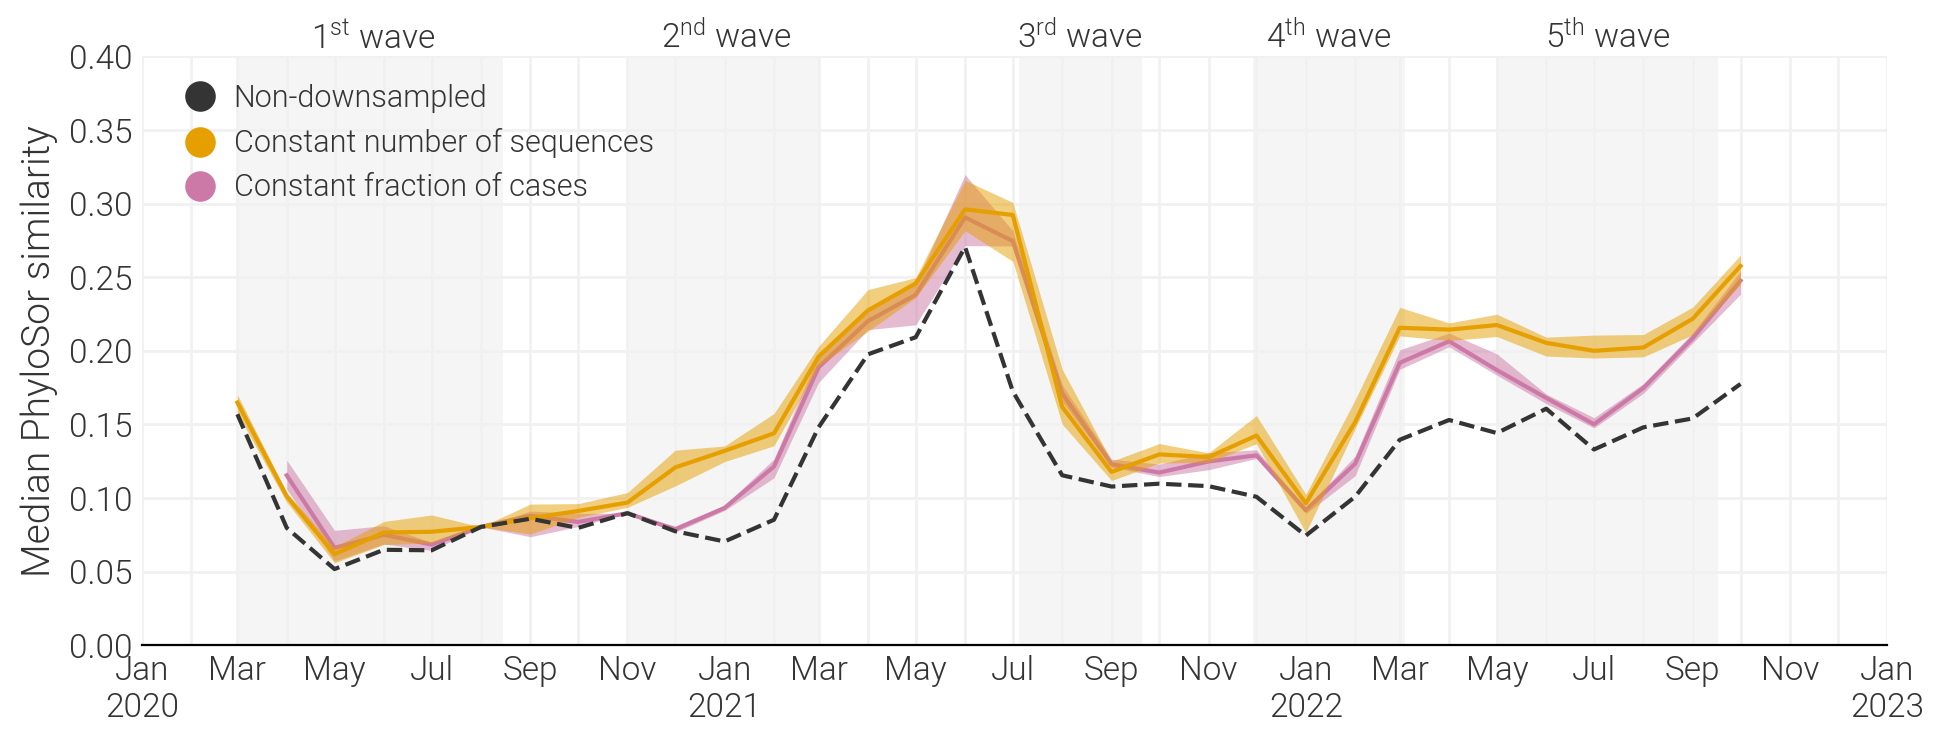

In [4]:
fig, ax = plt.subplots( dpi=200, figsize=(10,4) )

ax.plot( "date", "value", data=median_res, color=COLOR, linestyle="--", zorder=15 )
ax.plot( "date", "value_median", data=count_res, color="#E69F00", zorder=13 )
ax.fill_between( "date", "value_lower", "value_upper", data=count_res, linewidth=0, color="#E69F00", alpha=0.5, zorder=10 )
ax.plot( "date", "value_median", data=fraction_res, color="#CC79A7", zorder=8 )
ax.fill_between( "date", "value_lower", "value_upper", data=fraction_res, linewidth=0, color="#CC79A7", alpha=0.5, zorder=5 )

legend = [
    Line2D([0], [0], linestyle='none', marker='o', color=COLOR, label="Non-downsampled", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='o', color="#E69F00", label="Constant number of sequences", markersize=10 ),
    Line2D([0], [0], linestyle='none', marker='o', color="#CC79A7", label="Constant fraction of cases", markersize=10 ),
]

ax.legend( handles=legend, loc="upper left", handletextpad=0.1, frameon=False, fontsize=11 )
basic_formatting( ax, spines=["bottom"], which="both", xlims=( pd.to_datetime("2020-01-01"), pd.to_datetime("2023-01-01") ), ylims=(0, 0.4), ysize=12, xsize=12 )
ax.spines["bottom"].set_facecolor( "w" )
ax.set_ylabel( "Median PhyloSor similarity", fontsize=14)

ax.axvspan( "2020-03-01", "2020-08-15", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{1^{st}}$ wave", (pd.to_datetime( "2020-03-01" ), 0.4), (49,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2020-11-02", "2021-03-02", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{2^{nd}}$ wave", (pd.to_datetime( "2020-11-02" ), 0.4), (35,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2021-07-05", "2021-09-20", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate("$\mathregular{3^{rd}}$ wave", ( pd.to_datetime("2021-07-05" ), 0.4), (22,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2021-11-29", "2022-03-04", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{4^{th}}$ wave", (pd.to_datetime( "2021-11-29" ), 0.4), (27,3), textcoords="offset points", ha="center", fontsize=12 )
ax.axvspan( "2022-05-01", "2022-09-17", zorder=0, color="#000000", alpha=0.04, linewidth=0 )
ax.annotate( "$\mathregular{5^{th}}$ wave", (pd.to_datetime( "2022-07-01" ), 0.4), (5,3), textcoords="offset points", ha="center", fontsize=12 )

skipped_timeseries_formatting( ax )
ax.set_facecolor("w")

plt.tight_layout()
fig.savefig( "../analyses/plots/figureS7_phylosor-subsampling.pdf" )
fig.savefig( "../paper/figures/suppfigure7.pdf" )
fig.savefig( "../paper/figures/suppfigure7.png" )
plt.show()

Next we measure how closely the two subsampling scheme parallel results from using the non-downsampled dataset. We assess how similar the results are using Spearman correlation, and assess how much variance there is in the difference between the subsampling scheme and the non-downsampled dataset.

In [5]:
residuals = res.pivot_table( index="date", columns="kind", values="value", aggfunc="median" )
res_correlation = residuals.corr()
residuals = residuals.subtract( residuals["actual1"], axis=0 )
residuals = residuals.pow(2)
rmse = np.sqrt( residuals.mean() )

count_rmse = rmse[rmse.index.str.startswith( "count" )].mean()
count_corr = res_correlation.loc[res_correlation.index.str.startswith('count'),"actual1"].min()

fraction_rmse = rmse[rmse.index.str.startswith( "fraction" )].mean()
fraction_corr = res_correlation.loc[res_correlation.index.str.startswith('fraction'),"actual1"].min()

print( f"RMSE - Constant number of sequences: {count_rmse:.3f}")
print( f"RMSE - Constant fraction of cases: {fraction_rmse:.3f}")
print()
print( f"Correlation - Constant number of sequences: {count_corr:.1%}" )
print( f"Correlation - Constant fraction of cases: {fraction_corr:.1%}" )

RMSE - Constant number of sequences: 0.048
RMSE - Constant fraction of cases: 0.036

Correlation - Constant number of sequences: 90.5%
Correlation - Constant fraction of cases: 93.1%
